<div align="center">
<font size=4><b>
Evaluating classification models for the KOI dataset
</b>
<font size=3><b>
<br>Will Udstrand
<br>April 15, 2019
<br></font></b></div>

---

## Overview
There are over 100 billion galaxies in the observable universe each containing billions of stars and of those stars roughly 10 percent of them are hosts stars. Kepler objects of Interest are the stars that have been identified as potential hosts. These host stars are important when searching for planets outside our solar system. The goal of this notebook is to explore different classification techniques that could be employed in order to help classify KOIs. The KOI dataset provided by NASA contains the attributes of each KOI and their current classification as a host, candidate or a non-host star. With this dataset five different classification models will be trained and tested, then there individual performances will be compared in order to determine which model is best fit for classifying KOIs.

Classification models used
- Naive Bayes
- KNN
- Support Vector Machine
- Decision Tree
- Multilevel Perceptron (Neural Network) 



## References
* [KOI Dataset](https://www.kaggle.com/nasa/kepler-exoplanet-search-results)
* [Exoplanet Info](https://en.wikipedia.org/wiki/Exoplanet)
* [Kepler Objects of Interest Info](https://en.wikipedia.org/wiki/Kepler_object_of_interest)
* [Number of stars in the universe](https://www.ast.cam.ac.uk/public/ask/2360)
    
## Imports


In [2]:
# General Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
import sklearn
# Model Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import sklearn
import scikitplot as skplt

ModuleNotFoundError: No module named 'scikitplot'

## Helper Class

In [3]:
# This class is used for graphing box and wisker plots
class visualizer:
    def __init__(self, df, colname, fields, dimensions, figsize=None):
        self.df = df
        self.colname = colname
        self.fields = fields
        self.figsz = figsize
        self.dim = dimensions
        
    def data(self, field):
        vals = list(set(self.df[self.colname]))
        return [self.df[self.df[self.colname] == i][field].values for i in vals]
          
    def plot(self, ax, field):
        ax.set_title(field)
        ax.set_xlabel("Classification")
        sns.boxplot(ax=ax, data = self.data(field), showfliers=False)
    
    def graph(self):
        fig, axes = plt.subplots(nrows=self.dim[0], ncols=self.dim[1], figsize=self.figsz)
        for ax, field in zip(axes.reshape(-1), self.fields):
            self.plot(ax, field)
                       

## Data Eploration and Analysis

#### Kepler Exoplanet Data
The Kepler space observatory, a satellite built and monitored by NASA, was launched in 2009 with the hopes of discovering other planets that could inhabit life (i.e. Exoplanets). In order to find these planets the observatory must discover other solar systems. The observatory does this by identifying stars that have signatures that indicate transiting planets. These stars are called Kepler's objects of interest (KOI). Although their stellar fluctuations follow patterns consistent with that of a star that has transiting planets, some of the patterns identified are due to other influences. Therefore, there are KOIs that are hosts to planet(s) and some that mimic the signature of a host star. The following data is a record of all the Kepler objects of interest that the Kepler space observatory has been monitoring. 

[Data Field Descriptions](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html)


In [5]:
# Reading in the kepler exoplanet data from csv
kepler_df = pd.read_csv("data/cumulative.csv")

print("Dimensions: ", kepler_df.shape)
kepler_df.head()

Dimensions:  (9564, 50)


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


The Kepler objects of interest have three columns that describe their current classification.

| Column name      |  data type |  Description                                                            |
|------------------|------------|-------------------------------------------------------------------------| 
| koi_disposition  | object     |  Current classification of the KOI                                      | 
| koi_pdisposition | object     |  Identifies the most probable classification                            | 
| koi_score        | float64    |  Confidence value of the KOI's disposition (lower values are good for false positives)                              |

Each KOI can be classified in one of the following ways. 

| Classification | Meaning                                                                                 |
|----------------|-----------------------------------------------------------------------------------------|
| CONFIRMED (0)      | KOI is a host star                                                        |
| CANDIDATE (1)     | KOI has passed all prior tests used in identifying false positives |
| FALSE POSITIVE (2) | KOI is NOT a host star                |


#### Composition of Classifications

In [6]:
agg_fxns = {
    'koi_disposition': ['count'],
    'koi_score': ['mean']
}

kepler_df.groupby(['koi_disposition']).agg(agg_fxns)

,koi_disposition,koi_score
,count,mean
koi_disposition,,
CANDIDATE,2248,0.900210
CONFIRMED,2293,0.962597
FALSE POSITIVE,5023,0.014899


In [7]:
agg_fxns = {
    'koi_pdisposition': ['count'],
    'koi_score': ['mean']
}

kepler_df.groupby(['koi_pdisposition']).agg(agg_fxns)

,koi_pdisposition,koi_score
,count,mean
koi_pdisposition,,
CANDIDATE,4496,0.944312
FALSE POSITIVE,5068,0.015733


#### Cleaning the data

In [8]:
# Replace the enumerated values in the kepler_df
kepler_df = kepler_df.replace({'CONFIRMED': 0, 'CANDIDATE': 1, 'FALSE POSITIVE': 2})

# Clean the Data Frame by removing all labels, and error values
kepler_df = kepler_df.drop(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_tce_delivname', 
                     'koi_period_err1', 'koi_period_err2', 
                     'koi_time0bk_err1', 'koi_time0bk_err2', 
                     'koi_impact_err1', 'koi_impact_err2',
                     'koi_depth_err1', 'koi_depth_err2', 
                     'koi_prad_err1', 'koi_prad_err2', 
                     'koi_insol_err1', 'koi_insol_err2',
                     'koi_steff_err1', 'koi_steff_err2', 
                     'koi_slogg_err1', 'koi_slogg_err2', 
                     'koi_srad_err1', 'koi_srad_err2', 
                     'koi_duration_err1', 'koi_duration_err2', 
                     'koi_teq_err1', 'koi_teq_err2'], axis=1)

# Dealing with null data fields
# kepler_df.fillna(0, inplace=True)
kepler_df.fillna(kepler_df.mean(), inplace=True)

#### Correlations between columns
A lot of the fields within the dataset are of attributes that all KOIs have in common. Therefore most of the field will have little influence when trying to determine the classification of a KOI. Therefore, a correlation matrix can be used in order to identify which columns have an influence on the classification.

[Correlation Matricies](https://www.datascience.com/blog/introduction-to-correlation-learn-data-science-tutorials)

**NOTE: When analyzing the correlation between columns, columns that represented a label or error were disregarded.**

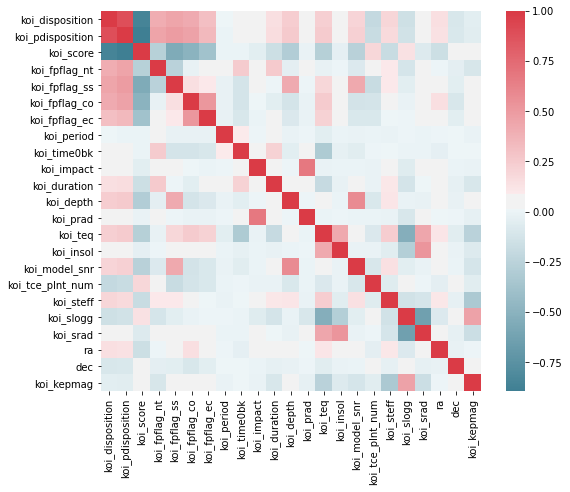

In [9]:
# Building a correlation matrix
corr = kepler_df.corr()
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

From the correlation matrix, columns with a value higher than 0.2 and lower that -0.2 when compared with the koi_disposition and koi_pdisposition columns, were extracted and identified as columns of interest.
  
| Column name      |  data type |  Description                                                            | 
|------------------|------------|-------------------------------------------------------------------------|
| koi_score        | float64    |  Confidence value of the KOI's disposition                              | 
| koi_fpflag_nt          | int64    |  A KOI whose light curve is not consistent with that of a transiting planet. This includes, but is not limited to, instrumental artifacts, non-eclipsing variable stars, and spurious (very low SNR) detections.      | 
| koi_fpflag_ss        | int64    |  A KOI that is observed to have a significant secondary event, transit shape, or out-of-eclipse variability, which indicates that the transit-like event is most likely caused by an eclipsing binary. However, self-luminous, hot Jupiter’s with a visible secondary eclipse will also have this flag set, but with a disposition of PC.                                              | 
| koi_fpflag_co        | int64    |  The source of the signal is from a nearby star, as inferred by measuring the centroid location of the image both in and out of transit, or by the strength of the transit signal in the target's outer (halo) pixels as compared to the transit signal from the pixels in the optimal (or core) aperture.                | 
| koi_fpflag_ec         | int64    |  The KOI shares the same period and epoch as another object and is judged to be the result of flux contamination in the aperture or electronic crosstalk.                                                   | 
| koi_depth       | float64    | The fraction of stellar flux lost at the minimum of the planetary transit.                                                           | 
| koi_teq       | float64    |  Approximation for the temperature of the planet.                                                           | 
| koi_model_snr       | float64    |  Transit depth normalized by the mean uncertainty in the flux during the transits.                                                            |  

#### Analysis of the columns of interest


In [10]:
agg_fxns = {
    'koi_score': ['mean'],
    'koi_fpflag_nt': ['mean'],
    'koi_fpflag_ss': ['mean'],
    'koi_fpflag_co': ['mean'],
    'koi_fpflag_ec': ['mean'],
    'koi_depth': ['mean'],
    'koi_teq': ['mean'],
    'koi_model_snr': ['mean']
}
kepler_df.groupby('koi_disposition').agg(agg_fxns).transpose()

,koi_disposition,0,1,2
koi_score,mean,0.960076,0.816073,0.112018
koi_fpflag_nt,mean,0.009158,0.000000,0.354171
koi_fpflag_ss,mean,0.011339,0.014235,0.429425
koi_fpflag_co,mean,0.002617,0.000000,0.369898
koi_fpflag_ec,mean,0.000436,0.000000,0.228350
koi_depth,mean,1151.324176,2478.743800,43664.768890
koi_teq,mean,839.233051,888.108233,1286.044468
koi_model_snr,mean,87.998297,51.601506,431.585806


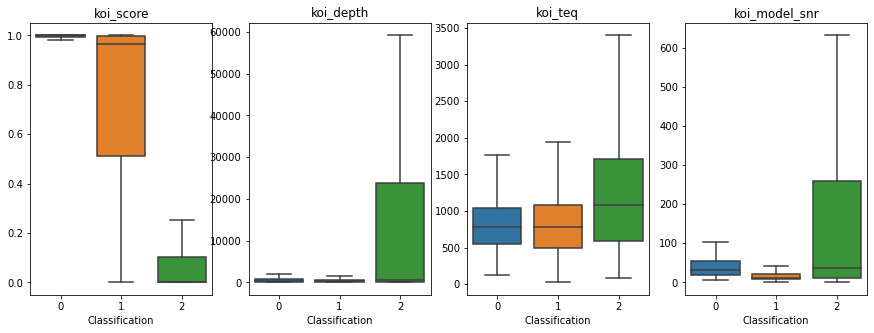

In [11]:
fields = ['koi_score', 'koi_depth', 'koi_teq', 'koi_model_snr']
id = 'koi_disposition'

v = visualizer(kepler_df, 'koi_disposition', fields, (1,4), (15,5))
v.graph()

The graphs and table above illustrate the distribution of the values for each classification type in koi_dispostion column. As we can see from the four graphs the distributions for CONFIRMED(0) and CANDIDATE (1) KOIs are pretty similar, whereas the FALSE POSITIVE (2) distributions seem to have more variation and higher medians.

In [12]:
kepler_df.groupby('koi_pdisposition').agg(agg_fxns).transpose()

,koi_pdisposition,1,2
koi_score,mean,0.896686,0.111909
koi_fpflag_nt,mean,0.000000,0.355170
koi_fpflag_ss,mean,0.009342,0.428769
koi_fpflag_co,mean,0.000000,0.367798
koi_fpflag_ec,mean,0.000000,0.226519
koi_depth,mean,1798.070209,43302.330874
koi_teq,mean,863.249179,1282.451016
koi_model_snr,mean,69.742835,428.585635


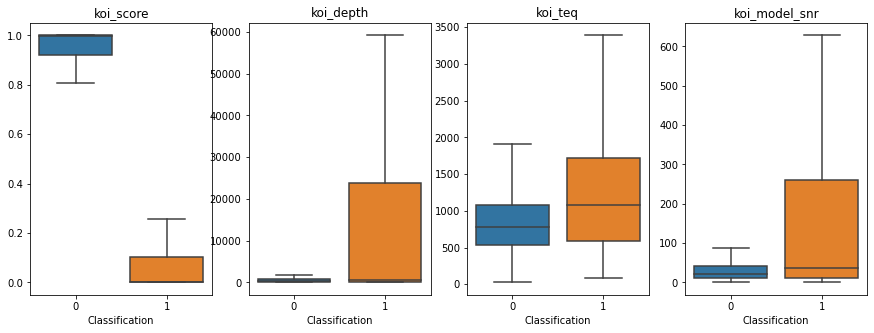

In [13]:
fields = ['koi_score', 'koi_depth', 'koi_teq', 'koi_model_snr']
id = 'koi_pdisposition'

v = visualizer(kepler_df, 'koi_pdisposition', fields, (1,4), (15,5))
v.graph()

The graphs and table above illustrate the distributions of the values for each classification type in koi_pdispostion column. As we can see from the four graphs the distributions for CANDIDATE (0) KOIs has less variability, variation and tends to have a lower median on average when compared to the FALSE POSITIVE (1) distribution.

#### Dimensionality Reduction
After exploring the data it is obvious that there are only a handful of data fields that actually correlate to the classification of the star. Therefore, there is no need for all of the fields within the dataset, so it can be reduced using PCA. By using PCA a majority of the variation within the data will be captured even though the dataset has been shrunk. Thus, classification on the smaller dataset will still have the same effect as on the larger set.  

[PCA Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit)

[PCA Description](https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe)


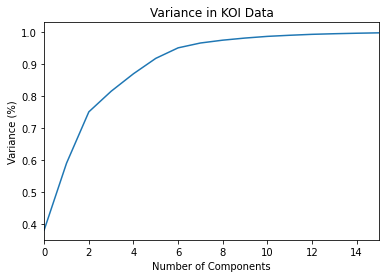

In [14]:
# kepler_df.dtypes

data = kepler_df.values

scaler = MinMaxScaler(feature_range=[0, 1])

# Removing first two columns because they are labels
rescaled_data = scaler.fit_transform(data[:, 2:])

pca = PCA().fit(rescaled_data)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.xlim((0,15))
plt.title('Variance in KOI Data')
plt.show()

As shown in the graph above there is only a need for eight principle components to capture the majority of the variance within the data as expected.  

In [15]:
pca = PCA(n_components=8)
dataset = pca.fit_transform(rescaled_data)
dataset.shape

(9564, 8)

#### Visualization of the Reduced Space

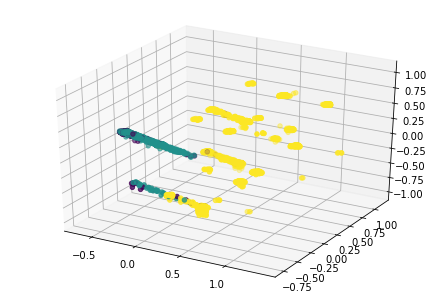

In [16]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], c=data[:,0])

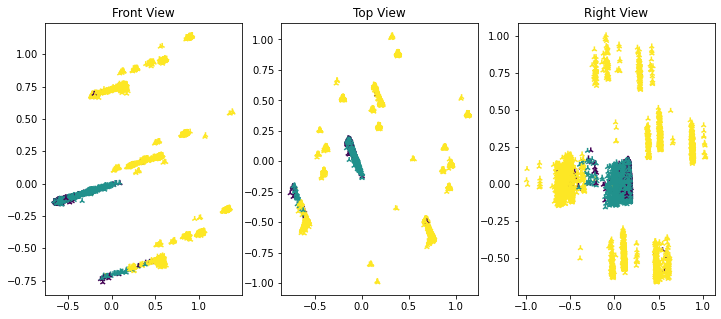

In [17]:
# Plot the differnt clusters
titles = ["Front View", "Top View", "Right View"]
marker = []
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
for i, ax in enumerate(axes.reshape(-1)):
    ax.scatter(dataset[:, i], dataset[:, i+1], c=data[:,0], marker="2")
    ax.set_title(titles[i])  

The graphs above illustrate the data set after it has been mapped to the lower space using only the first eight principle components. Visually it only shows the mapping of the first three principle components, and it is already apparent that there is separation between the FALSE POSITIVE labels and the other labels. This obvious separation signifies that the data will work well when classifying FALSE POSITIVE labels with different classification models. But also indicates that there will be difficulty when trying to distinguish between CONFIRMED and CANDIDATE labels due to their points overlapping.

#### Splitting data into training and test set

In [18]:
# classification = data[:, 1:2] # koi_pdisposition
classification = data[:, :1]
train, test, trainC, testC = train_test_split(dataset, classification, test_size=0.33, random_state=0)

print("Training set size: ", train.shape)
print("Test set size: ", test.shape)

Training set size:  (6407, 8)
Test set size:  (3157, 8)


## Models
Measurement Definitions
* **f1-score**:  F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. 
* **precision**: Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
* **recall**:  Recall is the ratio of correctly predicted positive observations to the all observations in actual class

[Sklearn Metrics Documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)


[Model Performance Interpretation](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)

In [22]:
# target_names = ['CANDIDATE', 'FALSE POSITIVE'] # koi_pdisposition
target_names = ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE']

def run_model(model):
    # Train and fit the model
    model.fit(train, trainC.ravel())
    # Predict the test data
    predictions = model.predict(test)
    # Compute model metrics
    overall_precision = np.mean(predictions == testC.ravel()) 
    print("Percentage of correct predictions: ", overall_precision)
    report = classification_report(predictions, testC, target_names=target_names, output_dict=True)
    #report = pd.DataFrame(data=report)
    report = pd.DataFrame(data=report).drop(['macro avg', 'weighted avg'], axis=1)
    print("\n", report)
    return report.drop(['precision', 'recall', 'support']) 

#### Naive Bayes
Naive Bayes is a supervised learning technique that utilizes Bayes’ Theorem along with some other assumptions about the conditional independence of the features to classify points. When classifying points, the label with the highest conditional probability is the label given to the point.

[Naive Bayes Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

[Naive Bayes Description](https://scikit-learn.org/stable/modules/naive_bayes.html)

In [23]:
gc = GaussianNB()
gc_report = run_model(gc)

Percentage of correct predictions:  0.8127969591384225

              CONFIRMED   CANDIDATE  FALSE POSITIVE  accuracy
precision     0.911171    0.352318        0.978300  0.812797
recall        0.594903    0.760000        0.972439  0.812797
f1-score      0.719830    0.481448        0.975361  0.812797
support    1138.000000  350.000000     1669.000000  0.812797


The precision metrics above for the Naive Bayes model indicates that when a data point is classified as CONFIRMED or FALSE POSITIVE it is right over 90% of the time, and only 35% of the time is it right when classified as a CANDIDATE. Additionally, the recall metric shows that the model only predicts 59% of the CONFIRMED labels, 76% of the CANDIDATE labels and 97% of the FALSE POSITIVE labels.

#### KNN
KNN is a supervised learning algorithm that uses the proximity of data points to classify new points. Rather than learning a function used to classify new data points, KNN keeps the entire training set and uses it to classify the new points. KNN classifies new points by looking at their k nearest neighbors, which is determine by some proximity measurement, and the most prominent label in the k neighbors is the label given to the new point.

[KNN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

[KNN Description](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

In [24]:
knn = KNeighborsClassifier(n_neighbors=7)
knn_report = run_model(knn)

Percentage of correct predictions:  0.8194488438390878

             CONFIRMED   CANDIDATE  FALSE POSITIVE  accuracy
precision    0.740242    0.541722        0.981314  0.819449
recall       0.622172    0.663961        0.982498  0.819449
f1-score     0.676091    0.596645        0.981906  0.819449
support    884.000000  616.000000     1657.000000  0.819449


The precision metrics above for the kth nearest neighbor model indicates that when a data point is classified as CONFIRMED it is right 62% of the time, if it is classified as a CANDIDATE it is right 35% of the time, and finally if it is classified as FALSE POSITIVE it is right 98% of the time. Additionally, the recall metric shows that the model only predicts 62% of the CONFIRMED labels, 66% of the CANDIDATE labels and 98% of the FALSE POSITIVE labels.

#### SVM
Support vector machines are a supervised learning model that tries to find the largest gap that separates the different labels within the data. It then uses this gap to determine the label of new points being classified.

[SVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

[SVM Description](https://en.wikipedia.org/wiki/Support-vector_machine)

In [25]:
svm = SVC(gamma='auto', probability=True)
svm_report = run_model(svm)

Percentage of correct predictions:  0.8089958821666139

              CONFIRMED   CANDIDATE  FALSE POSITIVE  accuracy
precision     0.947510    0.300662        0.978300  0.808996
recall        0.576105    0.796491        0.983636  0.808996
f1-score      0.716539    0.436538        0.980961  0.808996
support    1222.000000  285.000000     1650.000000  0.808996


The precision metrics above for the support vector machine indicates that when a data point is classified as CONFIRMED or FALSE POSITIVE it is right over 94% of the time, and only 30% of the time is it right when classified as a CANDIDATE. Additionally, the recall metric shows that the model only predicts 57% of the CONFIRMED labels, 79% of the CANDIDATE labels and 98% of the FALSE POSITIVE labels.

#### Decision Tree
The decision tree is a supervised learning model that predicts the value of a target variable by learning simple decision rules that are inferred from the data features.

[Decision Tree Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

[Decision Tree Description](https://scikit-learn.org/stable/modules/tree.html)

In [26]:
dt = tree.DecisionTreeClassifier()
dt_report = run_model(dt)

Percentage of correct predictions:  0.8039277795375356

             CONFIRMED   CANDIDATE  FALSE POSITIVE  accuracy
precision    0.643338    0.600000        0.968656  0.803928
recall       0.619974    0.616327        0.973349  0.803928
f1-score     0.631440    0.608054        0.970997  0.803928
support    771.000000  735.000000     1651.000000  0.803928


The precision metrics above for the decision tree model indicates that when a data point is classified as CONFIRMED it is right 66% of the time, if it is classified as a CANDIDATE it is right 58% of the time, and finally if it is classified as FALSE POSITIVE it is right 96% of the time. Additionally, the recall metric shows that the model only predicts 62% of the CONFIRMED labels, 62% of the CANDIDATE labels and 97% of the FALSE POSITIVE labels.


#### Neural Network
Neural networks are a supervised learning technique that uses the input data and their known labels to learn a non-linear function that takes an input and outputs a classification.

[Neural Network Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

[Neural Network Description](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

In [27]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)
nn_report = run_model(nn)

Percentage of correct predictions:  0.8292682926829268

              CONFIRMED   CANDIDATE  FALSE POSITIVE  accuracy
precision     0.881561    0.450331        0.978300  0.829268
recall        0.614447    0.758929        0.987827  0.829268
f1-score      0.724157    0.565254        0.983041  0.829268
support    1066.000000  448.000000     1643.000000  0.829268


E:\Users\Basharat\Anaconda3\envs\Bash\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


The precision metrics above for the neural network indicates that when a data point is classified as CONFIRMED it is right 79% of the time, if it is classified as a CANDIDATE it is right 58% of the time, and finally if it is classified as FALSE POSITIVE it is right 98% of the time. Additionally, the recall metric shows that the model only predicts 66% of the CONFIRMED labels, 72% of the CANDIDATE labels and 98% of the FALSE POSITIVE labels.

#### Model Analysis
[Scikitplot Documentation](https://scikit-plot.readthedocs.io/en/stable/)

NameError: name 'skplt' is not defined

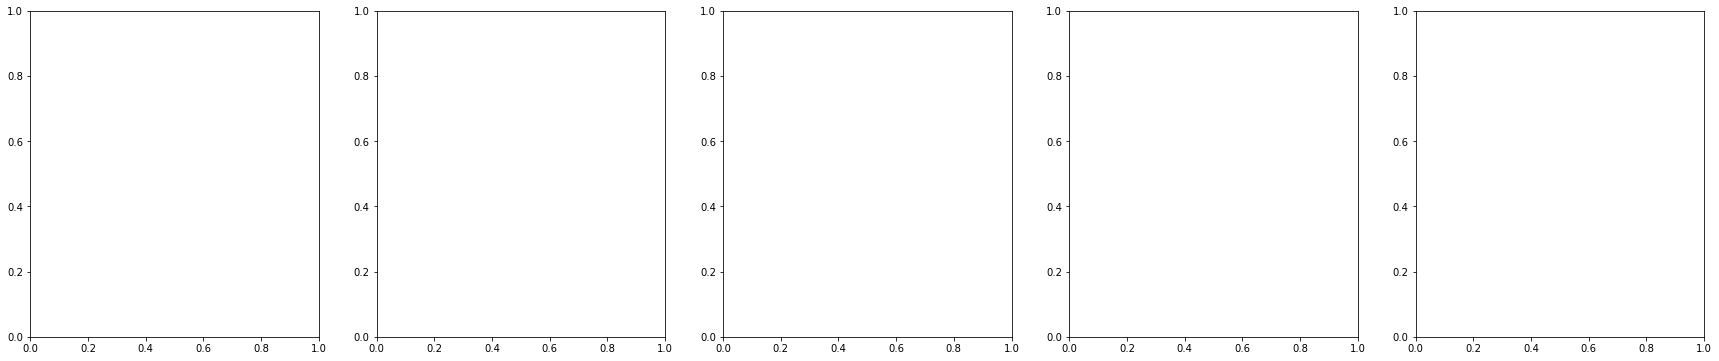

In [28]:
def plot_roc(ax, model, title):
    probas = model.predict_proba(test)
    skplt.metrics.plot_roc(y_true=testC, y_probas=probas, ax=ax, title=title)

models = [(gc, "Niave Bayes"), (knn, "knn"), (svm, "SVM"), (dt, "Decision Tree"), (nn, "Neural network")]
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30,6))
for ax, model in zip(axes, models):
    plot_roc(ax, model[0], model[1])

[ROC Curve Explanation](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

[Area Under the ROC Curve Explanation](http://gim.unmc.edu/dxtests/roc3.htm)

The ROC curve shows the relationship between the true positive rate (i.e. correct classifications) and the false positive rate (i.e. incorrect classifications) with the area under the curve representing the accuracy of the model predications. Therefore, the closer the area is to one the better and it's ideal to have a curve that approaches a true positive rate of one quickly.

In [29]:
reports = [gc_report, knn_report, svm_report, dt_report, nn_report]
cumulative = pd.DataFrame()
for report in reports:
    cumulative = pd.concat([cumulative, report])
    
cumulative.set_index(pd.Index(["Naive Bayes f1-score", "KNN f1-score",
                               "SVM f1-score", "Decision Tree f1-score", "Neural Network f1-score"]))

,CONFIRMED,CANDIDATE,FALSE POSITIVE,accuracy
Naive Bayes f1-score,0.719830,0.481448,0.975361,0.812797
KNN f1-score,0.676091,0.596645,0.981906,0.819449
SVM f1-score,0.716539,0.436538,0.980961,0.808996
Decision Tree f1-score,0.631440,0.608054,0.970997,0.803928
Neural Network f1-score,0.724157,0.565254,0.983041,0.829268


#### Individual Model Results
- **Naive Bayes**: The ROC curve shows that the naive Bayes model has high accuracy for each label and can achieve a high true positive rate with a relatively low false positive rate. Furthermore, the f1-score for the CONFIRMED and FALSE POSITIVE indicates high precision and recall for those labels. The lower f1-score reiterates that the precision value for the CANDIDATE label is low, thus the model doesn’t predict CANDIDATE labels very accurately.

- **KNN**: The ROC curve shows that the KNN model has high accuracy for each label and can achieve a high true positive rate with a relatively low false positive rate. Furthermore, the f1-score for the FALSE POSITIVE labels indicates high precision and recall for that label. The lower f1-score reiterates that the precision and recall value for the CANDIDATE label is low, thus the model doesn’t predict CANDIDATE labels very accurately, and it doesn’t recognize them very well.

- **SVM**: The ROC curve shows that the SVM has high accuracy for each label and can achieve a high true positive rate with a relatively low false positive rate. Furthermore, the f1-score for the CONFIRMED and FALSE POSITIVE indicates high precision and recall for those labels. The lower f1-score reiterates that the precision value for the CANDIDATE label is low, thus the model doesn’t predict CANDIDATE labels very accurately.

- **Decision Tree**: The ROC curve shows that the decision tree has a alright accuracy for each label, and can achieve a high true positive rate with a higher false positive rate. Furthermore, the f1-score for the CONFIRMED and FALSE POSITIVE indicates high precision and recall for those labels.

- **Neural Network**: The ROC curve shows that the neural network has high accuracy for each label and can achieve a high true positive rate with a relatively low false positive rate. Furthermore, the f1-score for the CONFIRMED and FALSE POSITIVE indicates high precision and recall for those labels. 

#### Model Error 
The models recall and precision values are lower for the CANDIDATE and CONFIRMED label due to the overlapping and coupled definitions for the two labels. 

## Conclusion
Each model is a viable candidate based off its accuracy, precision, and recall measurement. There are two type of classification approaches appropriate for this data set.

1. CANDIDATE vs. FALSE POSITIVE: Since each star labeled as CONFIRMED technically meets the requirement of a CANDIDATE star you could use the classifier to separate stars into a CONFIRMED/CANDIDATE group and a FALSE POSITIVE group. Providing a model that essentially flags stars as not important, thus thinning the number of stars to be confirmed. Based on the results of all the models each one could be used for this type of classifier, but the SVM would be the best due to it high precision rate in both CONFIRMED and FALSE POSITIVE labels.

2. A classifying model: This model would classify each star into its perspective label. Based on the results only the neural network has high enough scores all around to do this type of classification, and even with its scores it wouldn't perform exceedingly well.

Overall every model could be used but the two the standout the most are the neural network and the SVM. Additional work that could be done in order to better the performance of the classifiers would be parameter tuning , readjusting some of the model choices to better fit the distribution of the data, and exploring the use of the koi_pdisposition as a label. 